# Multi step join of monthly Sentinel-2 data to points of interest

This notebook rquires the following packages:

In [79]:
import geopandas as gpd
import geoengine as ge

First, connect to the Geo Engine instance:

In [80]:
ge.initialize("http://localhost:3030/api", credentials=("admin@localhost", "admin1234"))

In [81]:
session = ge.get_session()
user_id = session.user_id
session

Server:              http://localhost:3030/api
User Id:             d5328854-6190-4af9-ad69-4e74b0961ac9
Session Id:          59cc1127-5f75-4286-8f7e-0f2f1a2c662e
Session valid until: 2023-04-04T17:28:05.027Z

To track how much work is done, get the used quota:

In [82]:
used_quota_start = ge.get_quota(user_id)['used']
used_quota_start

0

Set the area of interest. It is defined as a bounding box in EPSG:32632.
It is locted in NRW, Germany and covers the area between Willingen, Lippstadt and Werl.

In [83]:
bounds_array = [421395,  5681078, 476201, 5727833]
xmin = bounds_array[0]
ymin = bounds_array[1]
xmax = bounds_array[2]
ymax = bounds_array[3]

(xmin, ymin, xmax, ymax)

(421395, 5681078, 476201, 5727833)

Using the bounding box, a time interval and a resolution, we define the area of interest as a temporal raster space-time cube.

In [84]:
from datetime import datetime
time_start = datetime(2021, 1, 1)
time_end = datetime(2021, 12, 31)

study_area = ge.api.RasterQueryRectangle(
    spatialBounds=ge.SpatialPartition2D(xmin, ymin, xmax, ymax).to_api_dict(),
    timeInterval=ge.TimeInterval(time_start, time_end).to_api_dict(),
    spatialResolution=ge.SpatialResolution(10.0, 10.0).to_api_dict(),
)
study_area

{'spatialBounds': {'upperLeftCoordinate': {'x': 421395, 'y': 5727833},
  'lowerRightCoordinate': {'x': 476201, 'y': 5681078}},
 'timeInterval': {'start': '2021-01-01T00:00:00.000+00:00',
  'end': '2021-12-31T00:00:00.000+00:00'},
 'spatialResolution': {'x': 10.0, 'y': 10.0}}

For the training, we use the Sentinel-2 data of the bands 02, 03, 04, and 08. The NDVI is calculated using an expression on band 4 and 8.

For each band as well as the mask (SCL), we create a workflow, that downloads the Sentinel-2 data for the area of interest and stores it as a new dataset.

In [7]:
status_download = {}

for b in ["B02", "B03", "B04", "B08", "SCL"]:
    print(b)
    sentinel2_band_workflow = ge.unstable.workflow_blueprints.sentinel2_band(b)
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_{b}")
    sentinel2_band_workflow_dataset_task.wait_for_finish(print_status=False)
    print(sentinel2_band_workflow_dataset_task.get_status())
    status_download[b] = sentinel2_band_workflow_dataset_task.get_status()

status_download

B02
status=completed, time_started=2023-04-03 19:10:50.007000+00:00, info={'dataset': 'a0630d89-fe7d-4087-98e4-aa496e681d50', 'upload': '2e448822-4938-47de-8c17-388e37c85eb6'}, time_total=00:41:41
B03
status=completed, time_started=2023-04-03 19:52:33.512000+00:00, info={'dataset': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83', 'upload': '5493c56c-762e-4842-b776-88f73d4bc524'}, time_total=00:41:26
B04
status=completed, time_started=2023-04-03 20:34:02.053000+00:00, info={'dataset': '6441f1f3-a9fb-4298-9161-eab91f0825e2', 'upload': 'e7c568df-eba4-44da-bc26-662e676f8bfc'}, time_total=00:42:40
B08
status=completed, time_started=2023-04-03 21:16:45.549000+00:00, info={'dataset': '66479fef-4295-48f1-99bf-670f6b7ea540', 'upload': 'b7f233e8-349f-47d8-9197-a042f1d34e4c'}, time_total=00:43:11
SCL
status=completed, time_started=2023-04-03 21:59:59.116000+00:00, info={'dataset': '4d243f03-f59b-4298-80e9-0fb5aa94926e', 'upload': '8a9ef64a-b57f-456a-9340-8ed5a5358a05'}, time_total=00:04:34


{'B02': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 3, 19, 10, 50, 7000, tzinfo=datetime.timezone.utc),info = {'dataset': 'a0630d89-fe7d-4087-98e4-aa496e681d50', 'upload': '2e448822-4938-47de-8c17-388e37c85eb6'}, time_total = '00:41:41'),
 'B03': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 3, 19, 52, 33, 512000, tzinfo=datetime.timezone.utc),info = {'dataset': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83', 'upload': '5493c56c-762e-4842-b776-88f73d4bc524'}, time_total = '00:41:26'),
 'B04': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 3, 20, 34, 2, 53000, tzinfo=datetime.timezone.utc),info = {'dataset': '6441f1f3-a9fb-4298-9161-eab91f0825e2', 'upload': 'e7c568df-eba4-44da-bc26-662e676f8bfc'}, time_total = '00:42:40'),
 'B08': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 3, 21, 16, 45, 549000, tzinfo=datetime.timezone.utc),info = {'dataset': '66479fef-4295-48f1-99bf-670f6b7e

Check the quota used for downloading the bands:

In [85]:
used_quota_download = ge.get_quota(user_id)['used'] - used_quota_start
used_quota_download

0

Using the bands dataset_ids, we create a map from band name to Geo Engine "InternalDataId". The "InternalDataId" is used to reference the datasets in the workflow.

In [86]:
## IF you ran the workflow, you can get the ids from the status
# band_data_map = { name: task_status.info['dataset'] for name, task_status in status_download.items() }
## IF you have the data already added, youn simply define the ids.
band_data_map = {
    'B02': 'a0630d89-fe7d-4087-98e4-aa496e681d50',
    'B03': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83',
    'B04': '6441f1f3-a9fb-4298-9161-eab91f0825e2',
    'B08': '66479fef-4295-48f1-99bf-670f6b7ea540',
    'SCL': '4d243f03-f59b-4298-80e9-0fb5aa94926e'
    }

band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=id) for name, id in band_data_map.items()
} 

band_data_id_map

{'B02': {'type': 'internal',
  'datasetId': 'a0630d89-fe7d-4087-98e4-aa496e681d50'},
 'B03': {'type': 'internal',
  'datasetId': '1cfd9d51-6cbf-4490-9ce6-da224a6f5a83'},
 'B04': {'type': 'internal',
  'datasetId': '6441f1f3-a9fb-4298-9161-eab91f0825e2'},
 'B08': {'type': 'internal',
  'datasetId': '66479fef-4295-48f1-99bf-670f6b7ea540'},
 'SCL': {'type': 'internal',
  'datasetId': '4d243f03-f59b-4298-80e9-0fb5aa94926e'}}

Now we create a workflow to aggregate each band to monthly means. We also create a monthly mean of the NDVI which is calculated using an expression on band 4 and 8. The resulting datasets are stored as new datasets.

In [87]:
status_agg = {}

for b in ["B02", "B03", "B04", "B08", "NDVI"]:
    print(b)
    sentinel2_band_workflow = ge.unstable.workflow_blueprints.s2_cloud_free_aggregated_band_custom_input(b, band_data_id_map, granularity="months", window_size=1, aggregation_type="mean")
    sentinel2_band_workflow_id = ge.register_workflow(sentinel2_band_workflow.to_workflow_dict())
    sentinel2_band_workflow_dataset_task = sentinel2_band_workflow_id.save_as_dataset(study_area, f"sentinel2_nrw_crop_10m_cf_monthly_{b}")
    sentinel2_band_workflow_dataset_task.wait_for_finish(print_status=False)
    print(sentinel2_band_workflow_dataset_task.get_status())
    status_agg[b] = sentinel2_band_workflow_dataset_task.get_status()

status_agg

B02
status=completed, time_started=2023-04-04 16:28:19.560000+00:00, info={'dataset': '68551371-47bf-4716-a5bc-ffbf350b40d8', 'upload': '6d74e670-6354-4652-8e76-da194448e6af'}, time_total=00:02:15
B03
status=completed, time_started=2023-04-04 16:30:35.072000+00:00, info={'dataset': 'a7c03fa3-e0b9-4e6a-bb2a-2576d0937f9c', 'upload': '02a4f73e-a9e2-4214-adec-93d10ccb797e'}, time_total=00:02:15
B04
status=completed, time_started=2023-04-04 16:32:55.339000+00:00, info={'dataset': '81daa5e9-5c4c-4d50-9abc-98b61e45a69b', 'upload': 'a723ad96-39e2-4d17-bc6a-e929c8bb1073'}, time_total=00:02:15
B08
status=completed, time_started=2023-04-04 16:35:15.776000+00:00, info={'dataset': 'bc9b1f99-f835-42d3-ace5-833b1dae81ca', 'upload': 'e549afca-2fc2-4174-afd8-f24d4a34f889'}, time_total=00:02:15
NDVI
status=completed, time_started=2023-04-04 16:37:36.048000+00:00, info={'dataset': '4047aa46-c02f-4019-8023-82aa15c22f4b', 'upload': '6c2253cb-7566-4aae-91dd-5bb5d4284db8'}, time_total=00:03:15


{'B02': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 4, 16, 28, 19, 560000, tzinfo=datetime.timezone.utc),info = {'dataset': '68551371-47bf-4716-a5bc-ffbf350b40d8', 'upload': '6d74e670-6354-4652-8e76-da194448e6af'}, time_total = '00:02:15'),
 'B03': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 4, 16, 30, 35, 72000, tzinfo=datetime.timezone.utc),info = {'dataset': 'a7c03fa3-e0b9-4e6a-bb2a-2576d0937f9c', 'upload': '02a4f73e-a9e2-4214-adec-93d10ccb797e'}, time_total = '00:02:15'),
 'B04': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 4, 16, 32, 55, 339000, tzinfo=datetime.timezone.utc),info = {'dataset': '81daa5e9-5c4c-4d50-9abc-98b61e45a69b', 'upload': 'a723ad96-39e2-4d17-bc6a-e929c8bb1073'}, time_total = '00:02:15'),
 'B08': TaskStatusInfo(status='completed', time_started=datetime.datetime(2023, 4, 4, 16, 35, 15, 776000, tzinfo=datetime.timezone.utc),info = {'dataset': 'bc9b1f99-f835-42d3-ace5-833b1

Check the quota used for aggregating the bands (and calculating NDVI):

In [88]:
used_quota_agg = ge.get_quota(user_id)['used'] - used_quota_download
used_quota_agg

819360

Again, we create a map from band name to Geo Engine "InternalDataId" for the aggregated bands.

In [89]:
## IF you ran the workflow, you can get the ids from the status
monthly_band_data_map = { name: task_status.info['dataset'] for name, task_status in status_agg.items() }
## IF you have the data already added, youn simply define the ids.
#monthly_band_data_map = {
#    'b02': '40f22cb2-3ef5-404d-a2ca-cb0a92f074b7',
#    'b03': '5f28373b-5fe5-4d29-b413-a55615037ab6',
#    'b04': 'b3a41f16-74fa-4d69-8b88-b2ffadf51d0e',
#    'b08': '9a70c853-3a8b-4f5a-95c3-4d2e51b7f900',
#    'ndvi': 'd2d4df69-0f1d-4b83-b9e5-3c5f1541e7cd'
#    }

monthly_band_data_id_map = {name: 
    ge.api.InternalDataId(
        type="internal",
        datasetId=id) for name, id in monthly_band_data_map.items()
} 


Upload the points to the Geo Engine:

In [90]:
points_df = gpd.read_file("group_sample_frac1_inspireId_use_utm32n.gpkg")
points_id = ge.upload_dataframe(points_df, "group_sample_frac1_inspireId")
points_id

82271425-3bde-442a-b57e-f9d37260a824

Create a souce operator that provides the points to a workflow:

In [147]:
points_source_operator = ge.unstable.workflow_operators.OgrSource(str(points_id))
points_source_operator.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'OgrSource',
  'params': {'data': {'type': 'internal',
    'datasetId': '82271425-3bde-442a-b57e-f9d37260a824'},
   'attributeProjection': None,
   'attributeFilters': None}}}

In [148]:
points_with_s2_cloud_free = ge.unstable.workflow_operators.RasterVectorJoin(
    raster_sources=[ge.unstable.workflow_operators.GdalSource(x) for x in monthly_band_data_id_map.values() ],
    vector_source=points_source_operator, #projected_points,
    new_column_names=[x for x in monthly_band_data_id_map.keys()],
)

points_with_s2_cloud_free.to_workflow_dict()

{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02', 'B03', 'B04', 'B08', 'NDVI'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'OgrSource',
    'params': {'data': {'type': 'internal',
      'datasetId': '82271425-3bde-442a-b57e-f9d37260a824'},
     'attributeProjection': None,
     'attributeFilters': None}},
   'rasters': [{'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '68551371-47bf-4716-a5bc-ffbf350b40d8'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': 'a7c03fa3-e0b9-4e6a-bb2a-2576d0937f9c'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': '81daa5e9-5c4c-4d50-9abc-98b61e45a69b'}}},
    {'type': 'GdalSource',
     'params': {'data': {'type': 'internal',
       'datasetId': 'bc9b1f99-f835-42d3-ace5-833b1dae81ca'}}},
    {'type': 'GdalSource',
     'params': {

In [149]:
points_with_s2_cloud_free_shift = points_with_s2_cloud_free

for month_delta in range(-8,0):
        points_with_s2_cloud_free_shift = ge.unstable.workflow_operators.RasterVectorJoin(
        raster_sources=[ge.unstable.workflow_operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=ge.unstable.workflow_operators.GdalSource(x)) for x in monthly_band_data_id_map.values() ],
        vector_source=points_with_s2_cloud_free_shift, #projected_points,
        new_column_names=[f'{x}_{month_delta}' for x in monthly_band_data_id_map.keys()],
    )


       
points_with_s2_cloud_free_shift.to_workflow_dict()


{'type': 'Vector',
 'operator': {'type': 'RasterVectorJoin',
  'params': {'names': ['B02_-1', 'B03_-1', 'B04_-1', 'B08_-1', 'NDVI_-1'],
   'temporalAggregation': 'none',
   'featureAggregation': 'mean'},
  'sources': {'vector': {'type': 'RasterVectorJoin',
    'params': {'names': ['B02_-2', 'B03_-2', 'B04_-2', 'B08_-2', 'NDVI_-2'],
     'temporalAggregation': 'none',
     'featureAggregation': 'mean'},
    'sources': {'vector': {'type': 'RasterVectorJoin',
      'params': {'names': ['B02_-3', 'B03_-3', 'B04_-3', 'B08_-3', 'NDVI_-3'],
       'temporalAggregation': 'none',
       'featureAggregation': 'mean'},
      'sources': {'vector': {'type': 'RasterVectorJoin',
        'params': {'names': ['B02_-4',
          'B03_-4',
          'B04_-4',
          'B08_-4',
          'NDVI_-4'],
         'temporalAggregation': 'none',
         'featureAggregation': 'mean'},
        'sources': {'vector': {'type': 'RasterVectorJoin',
          'params': {'names': ['B02_-5',
            'B03_-5',
    

To attach the Sentinel-2 data to the points, we use the raster-vector join operator. It takes a vector source (the points) and raster sources (the aggregated bands) as input and creates a point-time-series as output.

In [94]:


points_with_s2_cloud_free_shift.to_workflow_dict()

workflow = ge.register_workflow(points_with_s2_cloud_free_shift.to_workflow_dict())
workflow

29270ed6-0466-5bdd-a84c-93830543adce

Create datetime objects for the start and end of the time interval we use to query the final wrkflow:

In [95]:
start_dt = datetime(2021, 10, 1, 0, 0, 0)
end_dt = datetime(2021, 10, 1, 0, 0, 0)

start_dt, end_dt

(datetime.datetime(2021, 10, 1, 0, 0), datetime.datetime(2021, 10, 1, 0, 0))

Now, we query the workflow that attaches the Sentinel-2 data to the points from python and store the result in a gpkg file.

In [96]:
gp_res = await workflow.vector_stream_into_geopandas(
    ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=xmin,
            ymin=ymin,
            xmax=xmax,
            ymax=ymax,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
))

gp_res.to_file("gp_res_10_frac1_monthly_use_utm32n_multi_steps_12months_shift.gpkg", driver="GPKG")
gp_res

,B08,B04,B04_-8,INSPIRE_ID,NDVI_-7,NDVI_-6,B08_-6,B02,B03_-1,B03,...,ID,USE_CODE,B03_-8,B03_-2,B04_-4,B08_-1,NDVI_-1,geometry,time_start,time_end
0,1814.0,1166.0,580.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.263462,0.405934,4179.0,607.0,1164.0,873.0,...,0,OE,627.0,1048.0,670.0,2050.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,3555.0,703.0,693.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.321335,0.380573,3597.0,719.0,1174.0,970.0,...,1,GT,883.0,1602.0,555.0,2220.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,2369.0,1081.0,730.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.333275,0.294696,2788.0,683.0,1330.0,1007.0,...,2,GT,950.0,1492.0,467.0,2563.0,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,1530.0,221.0,183.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.108798,0.219950,1415.0,247.0,545.0,334.0,...,3,GL,141.0,386.0,247.0,2184.0,0.397063,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,3653.0,440.0,893.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.166214,0.222367,3084.0,399.0,541.0,704.0,...,4,GL,795.0,604.0,387.0,2754.0,0.406943,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,2209.0,953.0,787.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.134030,0.214256,3304.0,574.0,1007.0,833.0,...,49419,GT,816.0,916.0,431.0,2138.0,0.146780,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,3954.0,284.0,802.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.087611,0.118058,1848.0,193.0,384.0,419.0,...,49420,GT,546.0,488.0,1462.0,3918.0,0.449148,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,2379.0,860.0,939.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.106504,0.336000,3032.0,511.0,1121.0,805.0,...,49421,GT,819.0,854.0,700.0,2572.0,0.200596,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,4083.0,379.0,835.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.106873,0.117449,1439.0,280.0,465.0,544.0,...,49422,AF,689.0,858.0,1414.0,3965.0,0.429673,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


Check the quota used for querying the workflow:

In [97]:
used_quota_rvjoin = ge.get_quota(user_id)['used'] - used_quota_agg
used_quota_rvjoin

63257

In [98]:
import numpy as np
gp_train_1=gp_res.replace(np.nan, 0)#.groupby("USE_CODE").sample(n=300, replace=True)
gp_train_1

,B08,B04,B04_-8,INSPIRE_ID,NDVI_-7,NDVI_-6,B08_-6,B02,B03_-1,B03,...,ID,USE_CODE,B03_-8,B03_-2,B04_-4,B08_-1,NDVI_-1,geometry,time_start,time_end
0,1814.0,1166.0,580.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.263462,0.405934,4179.0,607.0,1164.0,873.0,...,0,OE,627.0,1048.0,670.0,2050.0,0.085486,MULTIPOINT (428690.027 5711938.189),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
1,3555.0,703.0,693.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.321335,0.380573,3597.0,719.0,1174.0,970.0,...,1,GT,883.0,1602.0,555.0,2220.0,0.134015,MULTIPOINT (427819.337 5710040.545),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
2,2369.0,1081.0,730.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.333275,0.294696,2788.0,683.0,1330.0,1007.0,...,2,GT,950.0,1492.0,467.0,2563.0,0.108832,MULTIPOINT (427320.866 5710158.178),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
3,1530.0,221.0,183.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.108798,0.219950,1415.0,247.0,545.0,334.0,...,3,GL,141.0,386.0,247.0,2184.0,0.397063,MULTIPOINT (431527.388 5693772.886),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
4,3653.0,440.0,893.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.166214,0.222367,3084.0,399.0,541.0,704.0,...,4,GL,795.0,604.0,387.0,2754.0,0.406943,MULTIPOINT (431535.193 5693614.690),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49419,2209.0,953.0,787.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.134030,0.214256,3304.0,574.0,1007.0,833.0,...,49419,GT,816.0,916.0,431.0,2138.0,0.146780,MULTIPOINT (472357.075 5696612.529),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49420,3954.0,284.0,802.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.087611,0.118058,1848.0,193.0,384.0,419.0,...,49420,GT,546.0,488.0,1462.0,3918.0,0.449148,MULTIPOINT (472016.875 5697690.039),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49421,2379.0,860.0,939.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.106504,0.336000,3032.0,511.0,1121.0,805.0,...,49421,GT,819.0,854.0,700.0,2572.0,0.200596,MULTIPOINT (471981.413 5696219.338),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00
49422,4083.0,379.0,835.0,https://geodaten.nrw.de/id/inspire-lu-ts/exist...,0.106873,0.117449,1439.0,280.0,465.0,544.0,...,49422,AF,689.0,858.0,1414.0,3965.0,0.429673,MULTIPOINT (471704.064 5697043.769),2021-10-01 00:00:00+00:00,2021-11-01 00:00:00+00:00


In [126]:
train_variable_order = ['B02', 'B02_-1', 'B02_-2', 'B02_-3', 'B02_-4',  'B02_-5',  'B02_-6', 'B02_-7', 'B02_-8',
        'B03', 'B03_-1', 'B03_-2', 'B03_-3', 'B03_-4',  'B03_-5',  'B03_-6', 'B03_-7', 'B03_-8',
        'B04', 'B04_-1', 'B04_-2', 'B04_-3', 'B04_-4',  'B04_-5',  'B04_-6', 'B04_-7', 'B04_-8',
        'B08', 'B08_-1', 'B08_-2', 'B08_-3', 'B08_-4',  'B08_-5',  'B08_-6', 'B08_-7', 'B08_-8',
        'NDVI', 'NDVI_-1', 'NDVI_-2', 'NDVI_-3', 'NDVI_-4',  'NDVI_-5',  'NDVI_-6', 'NDVI_-7', 'NDVI_-8']

x_list = gp_train_1[train_variable_order].values

In [100]:
y_list = gp_train_1['USE_CODE'].replace(0, 'None')
y_list

0        OE
1        GT
2        GT
3        GL
4        GL
         ..
49419    GT
49420    GT
49421    GT
49422    AF
49423    GL
Name: USE_CODE, Length: 49424, dtype: object

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.2, random_state=31337, stratify=y_list)

In [102]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
X = X_train
Y = y_train
clf = RandomForestClassifier(random_state=1337, class_weight='balanced_subsample', n_estimators=300)
clf = clf.fit(X, Y)
clf

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=300,
                       random_state=1337)

In [103]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score(y_test, clf.predict(X_test))

0.7725847243297926

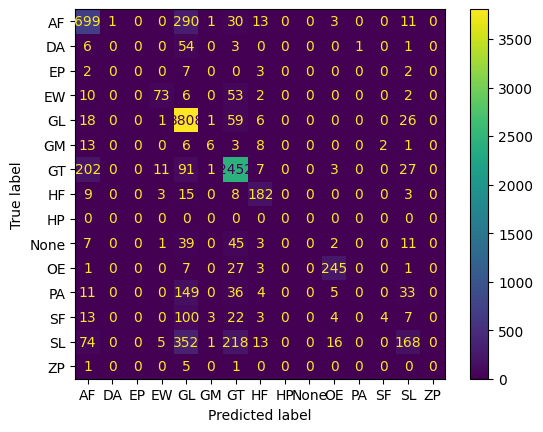

In [104]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [128]:


band_workflows_a = {b: ge.unstable.workflow_operators.GdalSource(x) for b, x in monthly_band_data_id_map.items()}

for month_delta in range(-8,0):
    for b in monthly_band_data_id_map.keys():
        w = band_workflows_a[b]
        band_workflows_a[f'{b}_{month_delta}'] = ge.unstable.workflow_operators.TimeShift(granularity="months", value=month_delta, shift_type="relative", source=w)

len(band_workflows_a)

# sort by input order used for the training and register the workflows
band_workflows_b = {b: ge.register_workflow(band_workflows_a[b].to_workflow_dict()) for b in train_variable_order }
band_workflows_b



{'B02': 9ca8d46f-82bc-58e4-94e6-be88fffa1793,
 'B02_-1': 1aace0cd-6aeb-543b-be9a-bee0723f7abc,
 'B02_-2': cf91ab8d-79d7-5fae-bd0a-d5ae0557d263,
 'B02_-3': 24f6bcf2-2b69-5a2e-b16e-16e0db06724a,
 'B02_-4': 01420922-fa5d-5a19-9659-e95d26295a1c,
 'B02_-5': 15d091ec-1380-5222-9ecf-966aa7acc579,
 'B02_-6': 0d61dd7d-7663-5499-9259-e3c007c79aac,
 'B02_-7': 9bae3f27-29c2-556c-bd35-3395160b455d,
 'B02_-8': d4637d6a-f916-5177-ab79-b8c5699e56d0,
 'B03': 0448dfb7-0b6d-58dc-a434-25173b22c265,
 'B03_-1': bb520475-2e34-5aca-a8a6-5e998c1b690f,
 'B03_-2': d705ee45-cac6-5d39-a0de-2076535ac3c7,
 'B03_-3': 7c63f1f6-8567-5131-af57-71a57324adb6,
 'B03_-4': 97811313-58cf-59da-a9c3-7f5d8bc09e41,
 'B03_-5': bfb89405-4cf3-5643-9a85-e0ae17bed225,
 'B03_-6': aa5929dd-819c-5abe-84e7-4c3faf7d0e6e,
 'B03_-7': 1e73bcfe-1324-57a6-b949-4a3a78d11805,
 'B03_-8': d1ec7e73-b854-5415-92d3-fd9e902b4704,
 'B04': fc89ec16-3802-5181-a5bb-0c3abfd769da,
 'B04_-1': 3feba758-f18f-515c-940a-c32bc8753a9c,
 'B04_-2': fa73e6ff-935b-55ae

In [154]:
start_dt = datetime(2021, 10, 15, 0, 0, 0)
end_dt = datetime(2021, 10, 15, 0, 0, 0)

box_size = 512

box_center_x = 0.5 * (xmin + xmax)
box_center_y = 0.5 * (ymin + ymax)

box_x_min = box_center_x - box_size / 2
box_x_max = box_x_min + box_size
box_y_min = box_center_y - box_size / 2
box_y_max = box_y_min + box_size

query_rect = ge.QueryRectangle(
        spatial_bounds=ge.BoundingBox2D(
            xmin=box_x_min,
            ymin=box_y_min,
            xmax=box_x_max,
            ymax=box_y_max,
        ),
        time_interval=ge.TimeInterval(
            start=start_dt,
            end=end_dt,
        ),
        resolution=ge.SpatialResolution(
            10.0,
            10.0,
        ),
        srs="EPSG:32632",
)

query_rect

QueryRectangle( 
    BoundingBox2D(xmin=448542.0, ymin=5704199.5, xmax=449054.0, ymax=5704711.5)
    TimeInterval(start=2021-10-15 00:00:00+00:00, end=2021-10-15 00:00:00+00:00)
    SpatialResolution(x=10.0, y=10.0)
    srs=EPSG:32632 
)

In [155]:
from asyncstdlib.itertools import zip_longest

query_keys = list(band_workflows_b.keys())
queryies = [
    w.raster_stream(query_rect) for w in band_workflows_b.values()
]

async for tile_stac in zip_longest(*queryies):
    print(len(tile_stac))
    print(tile_stac[0].shape)

ArrowInvalid: Negative buffer resize: -1

ArrowInvalid: Negative buffer resize: -1